In [1]:
import numpy as np
import FactorBP as FB
import scipy.io as sio
import matlab.engine
import time
eng = matlab.engine.start_matlab()

In [4]:
def ComputeAccurancy(Decode, gTruth, NofInliers):
    Ccnt = 0
    for i in range(NofInliers):
        if(Decode[i] == gTruth[i]):
            Ccnt += 1
    return 1.0 * Ccnt / NofInliers

def LoadHouse():
    res = np.zeros([111, 30, 2])
    for i in range(1,112):
        res[i-1] = np.loadtxt('data/cmum/house/label/house%d' %i)
    return res
HouseData = LoadHouse()
NofAlgorithms = 8
AlgorithmNames=['Ours', 'Ours-BCA', 'BCA', 'BCA-MP', 'BCA-IPFP', 'HGM', 'RRWHM', 'TM']
start = 0
end = 111
MeanAcc = np.zeros([10,NofAlgorithms])
MeanRtime = np.zeros([10, NofAlgorithms])
MeanObj = np.zeros([10, NofAlgorithms])
AllAcc = {}
AllRtim = {}
AllObj = {}
for baseline in xrange(10,101,10):
    print(' Start baseline: %d' % (baseline))
    AllAcc[(baseline-10)/10] = np.zeros([NofAlgorithms, end - baseline])
    AllRtim[(baseline-10)/10] = np.zeros([NofAlgorithms, end - baseline])
    # AllObj[(baseline-10)/10] = np.zeros([NofAlgorithms, end - baseline])
    Obj = np.zeros([NofAlgorithms, end - baseline])

    for ImageI in range(start, end - baseline):
        PT1 = np.copy(HouseData[ImageI])
        PT2 = np.copy(HouseData[ImageI+baseline])
        NofNodes = 30
        gTruth = np.random.permutation(NofNodes)
        PT1 = PT1[gTruth, :]
        PF1 = np.zeros([NofNodes,1])
        PF2 = np.zeros([NofNodes,2])
        MG1 = FB.MatchingGraph(PT1[0:NofNodes], PF1[0:NofNodes])
        MG2 = FB.MatchingGraph(PT2[0:NofNodes], PF2[0:NofNodes])

        [G, FName] = FB.ConstructMatchingModel(MG1, MG2, 'cmu', True, False)
        # G2 = FB.ConstructMatchingModel(MG1, MG2, 'cmu', False, True)
        [Gvis, FName] = FB.ConstructMatchingModel(MG1, MG2, 'cmu', True, False)
        G.SetVerbose(False)

        # Our results 1
        res1 = FB.BaBSolver(G, 30, 10, 0.005, False)
        AllAcc[(baseline-10)/10][0][ImageI] = ComputeAccurancy(res1.Decode, gTruth, NofNodes)
        AllRtim[(baseline-10)/10][0][ImageI] = res1.Time
        Obj[0][ImageI] = res1.Value
        #end Our results 1
        
        # BCA
        resBag = eng.runBcagm(FName, nargout=3)
        AllAcc[(baseline-10)/10][2][ImageI] = ComputeAccurancy(resBag[1][0], gTruth, NofNodes)
        AllRtim[(baseline-10)/10][2][ImageI] = resBag[0]
        cDecode = FB.intArray(NofNodes)
        for i in range(NofNodes):
            cDecode[i] = int(resBag[1][0][i])
        Obj[2][ImageI] = Gvis.ComputeObj(cDecode)
        #end BCA
        
        # BCA-MP
        resBagMP = eng.runBcagmQuad1(FName, 1,nargout=3)
        AllAcc[(baseline-10)/10][3][ImageI] = ComputeAccurancy(resBagMP[1][0], gTruth, NofNodes)
        AllRtim[(baseline-10)/10][3][ImageI] = resBagMP[0]
        for i in range(NofNodes):
            cDecode[i] = int(resBagMP[1][0][i])
        Obj[3][ImageI] = Gvis.ComputeObj(cDecode)
        #end BCA-MP
        
        # BCA-IPFP
        resBagIPFP = eng.runBcagmQuad1(FName, 2,nargout=3)
        AllAcc[(baseline-10)/10][4][ImageI] = ComputeAccurancy(resBagIPFP[1][0], gTruth, NofNodes)
        AllRtim[(baseline-10)/10][4][ImageI] = resBagIPFP[0]
        for i in range(NofNodes):
            cDecode[i] = int(resBagIPFP[1][0][i])
        Obj[4][ImageI] = Gvis.ComputeObj(cDecode)
        #end BCA-IPFP
        
        # HGM
        resHGM = eng.runHGM(FName, nargout=3)
        AllAcc[(baseline-10)/10][5][ImageI] = ComputeAccurancy(resHGM[1][0], gTruth, NofNodes)
        AllRtim[(baseline-10)/10][5][ImageI] = resHGM[0]
        for i in range(NofNodes):
            cDecode[i] = int(resHGM[1][0][i])
        Obj[5][ImageI] = Gvis.ComputeObj(cDecode)
        #end HGM
        
        # RRWHM
        resRRWHM = eng.runRRWHM(FName, nargout=3)
        #resRRWHM = eng.runBcagm(nargout=3)
        AllAcc[(baseline-10)/10][6][ImageI] = ComputeAccurancy(resRRWHM[1][0], gTruth, NofNodes)
        AllRtim[(baseline-10)/10][6][ImageI] = resRRWHM[0]
        for i in range(NofNodes):
            cDecode[i] = int(resRRWHM[1][0][i])
        Obj[6][ImageI] = Gvis.ComputeObj(cDecode)
        #end RRWHM
        
        # TensorMatching
        resTM = eng.runTensorMatching(FName, nargout=3)
        AllAcc[(baseline-10)/10][7][ImageI] = ComputeAccurancy(resTM[1][0], gTruth, NofNodes)
        AllRtim[(baseline-10)/10][7][ImageI] = resTM[0]
        for i in range(NofNodes):
            cDecode[i] = int(resTM[1][0][i])
        Obj[7][ImageI] = Gvis.ComputeObj(cDecode)
        #end TensorMatching
        
        # Our-BCA Results
        start_time = time.time()
        ResForBca = sio.loadmat(FName)
        X0 = np.zeros(NofNodes)
        X0Vec = res1.Decode
        for i in xrange(NofNodes):
            X0[i] = X0Vec[i]
        ResForBca['X0'] = X0
        sio.savemat(FName, ResForBca)
        resOursBCA = eng.runBcagm(FName, nargout=3)
        time_dur = time.time() - start_time

        cDecode = FB.intArray(NofNodes)
        #print(resOursBCA[1][0])
        for i in range(NofNodes):
            cDecode[i] = int(resOursBCA[1][0][i])
        if res1.Value < Gvis.ComputeObj(cDecode):
            AllAcc[(baseline-10)/10][1][ImageI] = ComputeAccurancy(resOursBCA[1][0], gTruth, NofNodes)
            Obj[1][ImageI] = Gvis.ComputeObj(cDecode)
        else:
            AllAcc[(baseline-10)/10][1][ImageI] = ComputeAccurancy(res1.Decode, gTruth, NofNodes)
            Obj[1][ImageI] = res1.Value
        AllRtim[(baseline-10)/10][1][ImageI] = time_dur + res1.Time
        #end Our-BCA Results
        
        MaxObj = np.max(Obj[:,ImageI])
        Obj[:,ImageI] /= MaxObj
        AllObj[(baseline-10)/10] = Obj
        #for ai in xrange(NofAlgorithms):
        #    print('%s Accuracy %f Running Time %f Obj %f' %(AlgorithmNames[ai], 
        #                                                     AllAcc[(baseline-10)/10][ai][ImageI],
        #                                                    AllRtim[(baseline-10)/10][ai][ImageI],
        #                                                   AllObj[(baseline-10)/10][ai][ImageI]))
        #print(' Finished Frame: %d ----------------------' % (ImageI) )
        #end inner loop
    for ai in xrange(NofAlgorithms):
        MeanAcc[(baseline-10)/10][ai] = np.mean(AllAcc[(baseline-10)/10][ai])
        MeanRtime[(baseline-10)/10][ai] = np.mean(AllRtim[(baseline-10)/10][ai])
        # MeanObj[(baseline-10)/10][ai] = np.mean(Obj[ai])
        MeanObj[(baseline-10)/10][ai] = np.mean(AllObj[(baseline-10)/10][ai])
        print('%s Accuracy %f Running Time %f Obj %f' %(AlgorithmNames[ai], 
                                                        MeanAcc[(baseline-10)/10][ai],
                                                        MeanRtime[(baseline-10)/10][ai],
                                                        MeanObj[(baseline-10)/10][ai]))
    print('××××××××××××××××××××')
    #end outer loop

 Start baseline: 10


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


Ours Accuracy 1.000000 Running Time 0.009004 Obj 1.000000
Ours-BCA Accuracy 1.000000 Running Time 0.037562 Obj 1.000000
BCA Accuracy 1.000000 Running Time 0.018011 Obj 1.000000
BCA-MP Accuracy 1.000000 Running Time 0.093568 Obj 1.000000
BCA-IPFP Accuracy 1.000000 Running Time 0.076360 Obj 1.000000
HGM Accuracy 0.807591 Running Time 0.003934 Obj 0.840986
RRWHM Accuracy 1.000000 Running Time 0.046375 Obj 1.000000
TM Accuracy 0.774917 Running Time 0.061660 Obj 0.863725
××××××××××××××××××××
 Start baseline: 20


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


Ours Accuracy 1.000000 Running Time 0.017288 Obj 1.000000
Ours-BCA Accuracy 1.000000 Running Time 0.046243 Obj 1.000000
BCA Accuracy 1.000000 Running Time 0.018045 Obj 1.000000
BCA-MP Accuracy 1.000000 Running Time 0.097822 Obj 1.000000
BCA-IPFP Accuracy 1.000000 Running Time 0.078259 Obj 1.000000
HGM Accuracy 0.735531 Running Time 0.003899 Obj 0.797988
RRWHM Accuracy 1.000000 Running Time 0.046902 Obj 1.000000
TM Accuracy 0.684982 Running Time 0.062826 Obj 0.824640
××××××××××××××××××××
 Start baseline: 30


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


Ours Accuracy 1.000000 Running Time 0.044493 Obj 1.000000
Ours-BCA Accuracy 1.000000 Running Time 0.072957 Obj 1.000000
BCA Accuracy 0.999177 Running Time 0.018342 Obj 0.999549
BCA-MP Accuracy 1.000000 Running Time 0.097591 Obj 1.000000
BCA-IPFP Accuracy 1.000000 Running Time 0.078460 Obj 1.000000
HGM Accuracy 0.671605 Running Time 0.003748 Obj 0.774584
RRWHM Accuracy 1.000000 Running Time 0.052786 Obj 1.000000
TM Accuracy 0.626337 Running Time 0.062151 Obj 0.806426
××××××××××××××××××××
 Start baseline: 40


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFa

FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


Ours Accuracy 1.000000 Running Time 0.106046 Obj 1.000000
Ours-BCA Accuracy 1.000000 Running Time 0.134457 Obj 1.000000
BCA Accuracy 0.995775 Running Time 0.017836 Obj 0.998386
BCA-MP Accuracy 0.999061 Running Time 0.101052 Obj 0.999856
BCA-IPFP Accuracy 0.999061 Running Time 0.078608 Obj 0.999856
HGM Accuracy 0.610329 Running Time 0.003698 Obj 0.752440
RRWHM Accuracy 0.998592 Running Time 0.058971 Obj 0.999905
TM Accuracy 0.573239 Running Time 0.061530 Obj 0.791789
××××××××××××××××××××
 Start baseline: 50


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


Ours Accuracy 1.000000 Running Time 0.141739 Obj 1.000000
Ours-BCA Accuracy 1.000000 Running Time 0.170270 Obj 1.000000
BCA Accuracy 0.993443 Running Time 0.018036 Obj 0.996708
BCA-MP Accuracy 1.000000 Running Time 0.106536 Obj 1.000000
BCA-IPFP Accuracy 1.000000 Running Time 0.080583 Obj 1.000000
HGM Accuracy 0.531694 Running Time 0.003796 Obj 0.728015
RRWHM Accuracy 1.000000 Running Time 0.060792 Obj 1.000000
TM Accuracy 0.508743 Running Time 0.061677 Obj 0.773002
××××××××××××××××××××
 Start baseline: 60


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFa

FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFa

FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFa

FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


Ours Accuracy 0.998693 Running Time 0.207385 Obj 0.999795
Ours-BCA Accuracy 1.000000 Running Time 0.235985 Obj 1.000000
BCA Accuracy 0.980392 Running Time 0.018149 Obj 0.994266
BCA-MP Accuracy 0.989542 Running Time 0.119753 Obj 0.998203
BCA-IPFP Accuracy 0.998693 Running Time 0.081603 Obj 0.999849
HGM Accuracy 0.475163 Running Time 0.003611 Obj 0.726346
RRWHM Accuracy 0.994118 Running Time 0.071700 Obj 0.999077
TM Accuracy 0.475163 Running Time 0.061522 Obj 0.774178
××××××××××××××××××××
 Start baseline: 70


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


Ours Accuracy 0.998374 Running Time 0.307777 Obj 1.000000
Ours-BCA Accuracy 0.998374 Running Time 0.336441 Obj 1.000000
BCA Accuracy 0.950407 Running Time 0.018058 Obj 0.986527
BCA-MP Accuracy 0.995935 Running Time 0.127184 Obj 0.998705
BCA-IPFP Accuracy 0.998374 Running Time 0.085649 Obj 1.000000
HGM Accuracy 0.432520 Running Time 0.003696 Obj 0.719301
RRWHM Accuracy 1.000000 Running Time 0.074326 Obj 0.999935
TM Accuracy 0.392683 Running Time 0.061830 Obj 0.766666
××××××××××××××××××××
 Start baseline: 80


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFa

FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


Ours Accuracy 0.995699 Running Time 0.330119 Obj 0.999685
Ours-BCA Accuracy 0.997849 Running Time 0.358307 Obj 1.000000
BCA Accuracy 0.897849 Running Time 0.018833 Obj 0.974292
BCA-MP Accuracy 0.944086 Running Time 0.150468 Obj 0.986929
BCA-IPFP Accuracy 0.986022 Running Time 0.089184 Obj 0.997951
HGM Accuracy 0.379570 Running Time 0.003656 Obj 0.717935
RRWHM Accuracy 1.000000 Running Time 0.093293 Obj 0.999970
TM Accuracy 0.322581 Running Time 0.062126 Obj 0.753160
××××××××××××××××××××
 Start baseline: 90


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFa

FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


Ours Accuracy 0.971429 Running Time 0.345050 Obj 0.994424
Ours-BCA Accuracy 0.979365 Running Time 0.373733 Obj 0.997479
BCA Accuracy 0.876190 Running Time 0.018732 Obj 0.972760
BCA-MP Accuracy 0.892063 Running Time 0.169705 Obj 0.978799
BCA-IPFP Accuracy 0.960317 Running Time 0.098177 Obj 0.994431
HGM Accuracy 0.323810 Running Time 0.003706 Obj 0.713097
RRWHM Accuracy 0.995238 Running Time 0.114961 Obj 0.999871
TM Accuracy 0.287302 Running Time 0.062098 Obj 0.761568
××××××××××××××××××××
 Start baseline: 100


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFa

FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFa

FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)
FactorBP/FactorGraph.py:399: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  def GetDecode(self): return _FactorGraph.CFactorGraph_GetDecode(self)


Ours Accuracy 0.887879 Running Time 0.336284 Obj 0.976182
Ours-BCA Accuracy 0.924242 Running Time 0.364488 Obj 0.992444
BCA Accuracy 0.766667 Running Time 0.019216 Obj 0.961381
BCA-MP Accuracy 0.775758 Running Time 0.189769 Obj 0.964752
BCA-IPFP Accuracy 0.969697 Running Time 0.103456 Obj 0.996433
HGM Accuracy 0.309091 Running Time 0.003493 Obj 0.727841
RRWHM Accuracy 0.936364 Running Time 0.202189 Obj 0.992158
TM Accuracy 0.281818 Running Time 0.062517 Obj 0.773986
××××××××××××××××××××


array([ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        0.99869281,  0.99837398,  0.99569892,  0.97142857,  0.88787879])

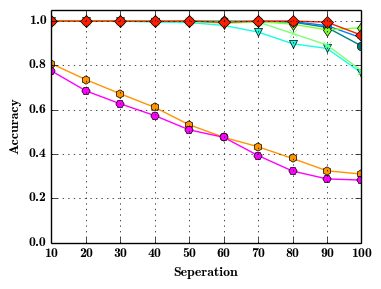

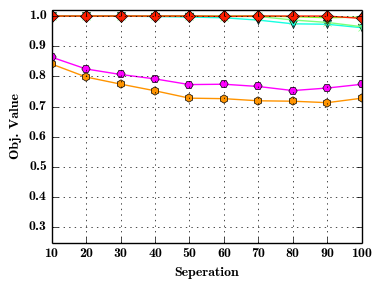

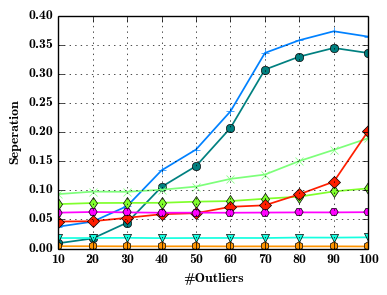

In [5]:
import matplotlib.pyplot as plt
import matplotlib
import pylab
%matplotlib inline

Colors = [[ 0.        ,  0.5       , 0.5        ,  1.        ],   #1
          # [ 1.        ,  0.00196078,  1.        ,  1.        ],   #2
          [ 0.        ,  0.50392157,  1.        ,  1.        ],   #3
          [ 0.08538899,  1.        ,  0.88235294,  1.        ],   #4
          [ 0.49019608,  1.        ,  0.47754586,  1.        ],   #5
          [ 0.5       ,  1.        ,  0.17273877,  1.        ],   #6
          [ 1.        ,  0.58169935,  0.        ,  1.        ],   #7
          [ 1.        ,  0.11692084,  0.        ,  1.        ],   #8
          [ 1.        ,  0.        ,  1.        ,  1.        ]];  #9
Seq = [0, 1, 2, 3, 4, 5, 6, 7]
AlgorithmNames=['Ours', 'Ours-BCA', 'BCA', 'BCA-MP', 'BCA-IPFP', 'HGM', 'RRWHM', 'TM']
Markers = ['o', '+', 'v', 'x', 'd', 'h', 'D', 'H']

figData = pylab.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
ax = pylab.gca()

matplotlib.rc('font',family='Times New Roman')


#plt.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')

for ai in xrange(NofAlgorithms):
    pylab.plot(range(10,101,10), MeanAcc[:,Seq[ai]], label=AlgorithmNames[Seq[ai]], 
             color=Colors[Seq[ai]], marker=Markers[Seq[ai]])
pylab.ylim([0,1.05])
pylab.grid(True)

pylab.ylabel('Accuracy')
pylab.xlabel('Seperation')


figLegend = pylab.figure(figsize = (11.7,0.4))
pylab.figlegend(*ax.get_legend_handles_labels(), loc = 'upper center',  ncol=9, shadow=True, fancybox=True)
figData.savefig('results/TripletsOnly/House_Acc.pdf')
#figLegend.savefig("legend.pdf")
figLegend.show()

#plt.legend(shadow=True, fancybox=True,loc='upper center', bbox_to_anchor=(0.5,-0.25), ncol=9)
#plt.savefig('House_ACC.pdf')    # <-- loses transparency

StoreForPlot ={}
StoreForPlot['Accuracy'] = MeanAcc
StoreForPlot['Time'] = MeanRtime
StoreForPlot['Obj'] = MeanObj

sio.savemat('results/TripletsOnly/PlotData.mat', StoreForPlot)

plt.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')


for ai in xrange(NofAlgorithms):
    if(AlgorithmNames[Seq[ai]] == 'Ours')|(AlgorithmNames[Seq[ai]] == 'Ours-BCA'):
        continue
    plt.plot(range(10,101,10), MeanObj[:,Seq[ai]], label=AlgorithmNames[Seq[ai]], 
             color=Colors[Seq[ai]], marker=Markers[Seq[ai]])
plt.ylim([0.25,1.02])
plt.ylabel('Obj. Value')
plt.xlabel('Seperation')
plt.grid(True)
plt.savefig('results/TripletsOnly/House_Obj.pdf')    # <-- loses transparency


plt.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')


for ai in xrange(NofAlgorithms):
    plt.plot(range(10,101,10), MeanRtime[:,Seq[ai]], label=AlgorithmNames[Seq[ai]], 
             color=Colors[Seq[ai]], marker=Markers[Seq[ai]], linewidth=1.25)

plt.ylabel('Seperation')
plt.xlabel('#Outliers')

plt.grid(True)
plt.savefig('results/TripletsOnly/Car_Time.pdf')    # <-- loses transparency

MeanAcc[:,0]

In [16]:
PT1 = np.copy(HouseData[ImageI])
PT2 = np.copy(HouseData[ImageI+baseline])
NofNodes = 30
gTruth = np.random.permutation(NofNodes)
PT1 = PT1[gTruth, :]
PF1 = np.zeros([NofNodes,1])
PF2 = np.zeros([NofNodes,2])
MG1 = FB.MatchingGraph(PT1[0:NofNodes], PF1[0:NofNodes])
MG2 = FB.MatchingGraph(PT2[0:NofNodes], PF2[0:NofNodes])
G = FB.ConstructMatchingModel(MG1, MG2, 'cmu', True, False)
res1 = FB.BaBSolver(G, 30, 10, 0.005, True)

BaBIter=1, GUB = 100000000000000000000.000000, GLB = -100000000000000000000.000000, Gap = 2.00, Time=0.0027
